# PROJECT 2 - LSTM

## Samuel Norris and Arjun Mishra

This initial section of the project fulfills the basic requirements of developing LSTM models and ultimately being able to predict, with some level of accuracy, the language a given string comes from.  The languages considered in this section are English and French.  We train an English model and a French model.  Then, we predict the probability of seeing a certain string given that it is from an English text as well of the probability of seeing that same string given that it is from a French text.  Whichever log likelihood is greater is the language we predict for that string.

The code below is based on the code found at https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py.  Code is also taken from past homeworks of Sam Norris.  We attempt to include citations of outside sources where they were present in past homeworks, and any omission of such citations is unintentional.  We also used the other recommended blog posts and code, which we do not cite further as we consider this to be assumed.

In [80]:
# Import necessary libraries (some imported later in the code) and read in data

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path_eng = get_file('eng.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/eng.txt')
text_eng = open(path_eng).read().lower()
print('English Corpus Length:\t', len(text_eng))

path_frn = get_file('frn.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/frn.txt')
text_frn = open(path_frn).read().lower()
print('French Corpus Length:\t', len(text_frn))

English Corpus Length:	 10746
French Corpus Length:	 12009


In [81]:
# Get chars from two texts
chars_from_eng = sorted(list(set(text_eng)))
chars_from_frn = sorted(list(set(text_frn)))

# Combine chars from two languages into one chars list
#######################
# Code between hash lines taken from 
# http://stackoverflow.com/questions/2151517/pythonic-way-to-create-union-of-all-values-contained-in-multiple-lists
results_list = [chars_from_eng, chars_from_frn]
chars = list(set().union(*results_list))
#######################

# Get dictionaries of chars and their index in the chars list
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('Total Chars:\t', len(chars))

Total Chars:	 44


In [82]:
# Break up English text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_eng = []
next_chars_eng = []
for i in range(0, len(text_eng) - maxlen, step):
    char5_strings_eng.append(text_eng[i: i + maxlen])
    next_chars_eng.append(text_eng[i + maxlen])
print('English 5-char sequences:\t', len(char5_strings_eng))

# Break up French text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_frn = []
next_chars_frn = []
for i in range(0, len(text_frn) - maxlen, step):
    char5_strings_frn.append(text_frn[i: i + maxlen])
    next_chars_frn.append(text_frn[i + maxlen])
print('French 5-char sequences:\t', len(char5_strings_frn))

English 5-char sequences:	 10741
French 5-char sequences:	 12004


In [83]:
# Get the labels for the datasets
# 1=English, 0=French
labels_eng = np.array([1]*len(char5_strings_eng))
labels_frn = np.array([0]*len(char5_strings_frn))

In [84]:
from sklearn.model_selection import train_test_split, cross_val_predict, learning_curve

# Do an 80/20 split to get training and test data for both English and French
training_data_eng, testing_data_eng, training_labels_eng, testing_labels_eng = train_test_split(
        char5_strings_eng, labels_eng, test_size=0.2, random_state=0)

training_data_frn, testing_data_frn, training_labels_frn, testing_labels_frn = train_test_split(
        char5_strings_frn, labels_frn, test_size=0.2, random_state=0)

In [85]:
# Method to vectorize a dataset
def vectorization(char5_strings, maxlen, chars, char_indices, next_chars):
    X = np.zeros((len(char5_strings), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(char5_strings), len(chars)), dtype=np.bool)
    for i, char5_string in enumerate(char5_strings):
        for t, char in enumerate(char5_string):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

In [86]:
X_train_eng, X_train_labels_eng = vectorization(training_data_eng, maxlen, chars, char_indices, next_chars_eng)
X_test_eng, X_test_labels_eng = vectorization(testing_data_eng, maxlen, chars, char_indices, next_chars_eng)

X_train_frn, X_train_labels_frn = vectorization(training_data_frn, maxlen, chars, char_indices, next_chars_frn)
X_test_frn, X_test_labels_frn = vectorization(testing_data_frn, maxlen, chars, char_indices, next_chars_frn)

In [87]:
# Build the English model: a single LSTM
print('Building English model')
model_eng = Sequential()
model_eng.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_eng.add(Dense(len(chars)))
model_eng.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model_eng.compile(loss='categorical_crossentropy', optimizer=optimizer)


# Build the French model: a single LSTM
print('Building French model')
model_frn = Sequential()
model_frn.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_frn.add(Dense(len(chars)))
model_frn.add(Activation('softmax'))

model_frn.compile(loss='categorical_crossentropy', optimizer=optimizer)

Building English model
Building French model


In [88]:
# train the English model
for iteration in range(1, 60): # Make it 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_eng.fit(X_train_eng, X_train_labels_eng,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
8592/8592 [==============================] - 2s - loss: 3.0107     
Epoch 2/5
8592/8592 [==============================] - 1s - loss: 2.9438     
Epoch 3/5
8592/8592 [==============================] - 1s - loss: 2.9343     
Epoch 4/5
8592/8592 [==============================] - 2s - loss: 2.9224     
Epoch 5/5
8592/8592 [==============================] - 1s - loss: 2.9085     

--------------------------------------------------
Iteration 2
Epoch 1/5
8592/8592 [==============================] - 1s - loss: 2.8860     
Epoch 2/5
8592/8592 [==============================] - 1s - loss: 2.8591     
Epoch 3/5
8592/8592 [==============================] - 1s - loss: 2.8208     
Epoch 4/5
8592/8592 [==============================] - 1s - loss: 2.7727     
Epoch 5/5
8592/8592 [==============================] - 1s - loss: 2.7143     

--------------------------------------------------
Iteration 3
Epoch 1/5
8592/8592 [=======

In [89]:
# train the French model
for iteration in range(1, 60): # Make this 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_frn.fit(X_train_frn, X_train_labels_frn,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
9603/9603 [==============================] - 2s - loss: 2.9044     
Epoch 2/5
9603/9603 [==============================] - 1s - loss: 2.8414     
Epoch 3/5
9603/9603 [==============================] - 1s - loss: 2.8344     
Epoch 4/5
9603/9603 [==============================] - 2s - loss: 2.8242     
Epoch 5/5
9603/9603 [==============================] - 1s - loss: 2.8091     

--------------------------------------------------
Iteration 2
Epoch 1/5
9603/9603 [==============================] - 1s - loss: 2.7915     
Epoch 2/5
9603/9603 [==============================] - 2s - loss: 2.7730     
Epoch 3/5
9603/9603 [==============================] - 1s - loss: 2.7417     
Epoch 4/5
9603/9603 [==============================] - 1s - loss: 2.7056     
Epoch 5/5
9603/9603 [==============================] - 1s - loss: 2.6589     

--------------------------------------------------
Iteration 3
Epoch 1/5
9603/9603 [=======

In [90]:
# Create the 200 test data
test_data_200 = np.zeros((200, maxlen, len(chars)), dtype=np.bool)

# Pick 100 substrings at random from each language
eng_test_indices = np.random.randint(0, X_test_eng.shape[0], size=100)
frn_test_indices = np.random.randint(0, X_test_frn.shape[0], size=100)

# Fill the data
test_data_200[:100] = X_test_eng[eng_test_indices,:,:]
test_data_200[100:] = X_test_frn[frn_test_indices,:,:]

# Create the labels
test_labels_200 = np.concatenate(([1]*100, [0]*100))

In [91]:
# Vectorize test string
def test_vectorization(test_string, maxlen, chars, char_indices):
    # Create array to handle broken up test string
    test_string_data = []
    
    # Break up test string
    for ind in range(min(maxlen, len(test_string))):
        test_string_data.append(test_string[:ind])
   
    # Create X
    X = np.zeros((len(test_string_data), maxlen, len(chars)), dtype=np.bool)
    for i, test_string_entry in enumerate(test_string_data):
        for t, char in enumerate(test_string_entry):
            X[i, t, char_indices[char]] = 1
    return X

In [92]:
test_predict_200 = np.zeros(200)
test_y_hat_200 = np.zeros(200)

for t in range(test_data_200.shape[0]):
    letter_string = ''
    for letter in range(maxlen):
        letter_ind = np.where(test_data_200[t,letter,:]==1)[0][0]
        letter_string += chars[letter_ind]
    letter_string_vect = test_vectorization(letter_string, maxlen, chars, char_indices)
    
    test_predict_eng = model_eng.predict(letter_string_vect, batch_size=1, verbose=1)
    test_predict_frn = model_frn.predict(letter_string_vect, batch_size=1, verbose=1)
    total_prob_eng = 1
    total_prob_frn = 1
    for p in range(len(test_predict_eng)):
        """if len(np.where(test_data_200[t,p,:]==1)[0]) == 0:
            print('BREAK')
            break"""
        char_ind = np.where(test_data_200[t,p,:]==1)[0][0]
        # English probability
        char_prob_eng = test_predict_eng[p, char_ind]
        total_prob_eng *= char_prob_eng
        # French probability
        char_prob_frn = test_predict_frn[p, char_ind]
        total_prob_frn *= char_prob_frn
    prediction = 1 if (np.log(total_prob_eng) > np.log(total_prob_frn)) else 0
    test_predict_200[t] = prediction
    test_y_hat_200[t] = np.log(total_prob_eng) - np.log(total_prob_frn)

1/5 [=====>........................] - ETA: 0s

In [93]:
accuracy_vect = np.nonzero(test_labels_200 - test_predict_200)
accuracy = 1 - (len(accuracy_vect[0]) / 200.)
print(accuracy)

0.62


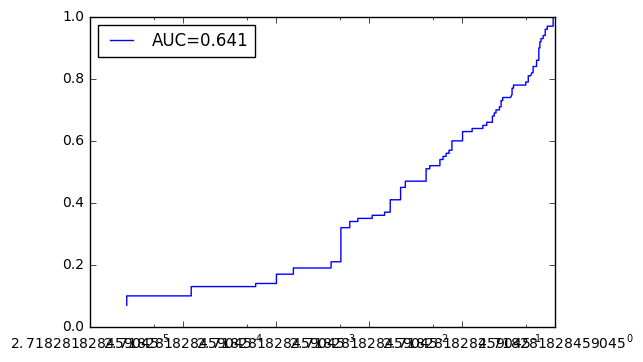

In [94]:
# Code from
# http://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python

from sklearn import metrics
import matplotlib.pyplot as plt
import math

plt.figure(0).clf()

auc = metrics.roc_auc_score(test_labels_200, test_y_hat_200)
fpr, tpr, thresholds = metrics.roc_curve(test_labels_200, test_y_hat_200)
plt.semilogx(basex = math.e)
plt.plot(fpr, tpr, label="AUC="+str(auc))
#plt.plot([0, 1], [0, 1], color='gray')

plt.legend(loc=0)
plt.show()

### Our Model Performance
Given the small size of the training data (files are 11-12 KB, and in one of the recommended blog posts for this assingment, Karpathy refers to a 1MB text file as small), our performance seems pretty good.  In testing with this model, accuracies between 55% and 65.5% were common.  The AUC also seems respectable.  The minor variations in model performance are likely due to the random sampling of 100 strings per language from the test data.  Overall, I would say the model performs well.
***

### Discussion of why LSTM is good for language detection compared to other models
We wanted to point out the merits of LSTMs over other models.  The following paragraph is taken directly from https://arxiv.org/abs/1308.0850v5.

_"RNNs are ‘fuzzy’ in the sense that they do not use exact templates from
the training data to make predictions, but rather—like other neural networks—
use their internal representation to perform a high-dimensional interpolation
between training examples. This distinguishes them from n-gram models and
compression algorithms such as Prediction by Partial Matching [5], whose predictive
distributions are determined by counting exact matches between the
recent history and the training set. The result—which is immediately apparent from the samples in this paper—is that RNNs (unlike template-based algorithms)
synthesise and reconstitute the training data in a complex way, and
rarely generate the same thing twice. Furthermore, fuzzy predictions do not suffer
from the curse of dimensionality, and are therefore much better at modelling
real-valued or multivariate data than exact matches.
 As well as diminishing
their ability to model long-range structure, this ‘amnesia’ makes them prone to
instability when generating sequences. The problem (common to all conditional
generative models) is that if the network’s predictions are only based on the last
few inputs, and these inputs were themselves predicted by the network, it has
little opportunity to recover from past mistakes. Having a longer memory has
a stabilising effect, because even if the network cannot make sense of its recent
history, it can look further back in the past to formulate its predictions."_
***

### Three alternatives to language detection
### 1
The n-gram approach: The n-gram model is a (n-1) order Markov model which uses the previous n-1 'grams' to predict the next gram. These grams can be words, syllables, phenomes etc. The model makes an independence assumption i.e. the nth gram only depends on the previous n-1 grams, to solve the Markov model effectively. For language detection, we could train n-gram models in different languages and finally feed it new paragraphs to arrive at the probability of the paragraph belonging to a particular language. The probability will be based on how often n-grams from a particular language appear in the new text. This is like using an expectation maximization algorithm.


Some of the advantages of the n-gram approach are:
1. It does not require building up a huge dictionary like the bag of words approach or other profiling algorithms. Thus the long time to search through the library is avoided.
2. Unlike the vanilla BOW and other profiling models, it can find structure and patterns in the language. For example, it might find that it is common for the letter 'u' to follow the letter 'q' in English.
3. This model is robust to getting new words in a paragraph, compared to what it was trained on.

The n-gram approach struggles in the following areas:
1. Language identification on very short texts - The n-gram model is not able to develop sufficient context understanding in short datasets to provide good predictions.
2. A n-gram model would also provide us poor accuracy when the text we are analyzing comprise of multiple languages. It wouldn't be able to correctly handle texts of an unknown language.
3. As the name suggests, we can use different length 'grams' in our model. We can feed bigrams, trigrams and quadgrams at the same time for a more stable model. n-grams also use words from either side of a particular word so the context developed by the model is much stronger. The n can also be anything - words, syllables, letters etc. and we can customize accordingly.

### 2
The dictionary approach: The most obvious way that anyone can think of when doing language detection is the formation of a
word dictionary for each language. A list of common words used in a language will be the most simple and effective corpus for detecting a particular language. For example, articles like a, an, the would be some of the words for the English language.
Depending on the type of corpus we have created, we can use a profiling algorithm that best works with it.
The most straightforward use case for this approach is using the most common words in the language as the corpus. Once the corpus is formed, we find the distance between the standard corpus and our target document, which will be equal to the sum of differences between the frequencies of matching words.
A variation of this model could be using character sets instead of formulated words. The idea is to map fequencies of the character sets and identify commonly used sets.

These algorithms suffer from the following drawbacks:

Since the frequency of matching words is very less, the algorithm cannot efficiently work with small texts having few sentences. It needs a lot of text for accurate match.

It cannot detect word boundaries for languages having compound sentences, and those having no word dividers like spaces or punctuation marks.

It is difficult to differentiate two languages having similar character frequencies.

Some of the pro's of this approach are:

They are fairly simple to develop and very easy to use. Once a versatile corpora has been created for each language, large paragraphs can easily be classified into their respective languages without a lot of effort.

It is very easy to understand what this method is doing. Compared to highly complex models like LSTMs, this approach is highly simplistic.

### 3
A third alternative for language identification is also based on the n-gram approach but also applies a machine learning model on top of it. First we count character n-gram occurrences in a given text, for n up to some maximum length, and use these counts as
the features in a classification model. SVMs are appropriate in this problem as they can take a large number of features and learn to weigh them appropriately. The standard n-gram model is a Markov model using the text to map the probabilities of the next occurence and then appropriately assigning it to a language. A classification model will use the counts of the n-grams to directly arrive at a classification of the language when already trained on a corpus of documents.

The main advantages of this approach are:
1. We can use features apart from just the n-gram counts. Some examples of features might be - using the word count in a document, the average character length of words etc. We can also incorporate distance and similarity features. For example, we can have a document as the standard English document and we can measure the Jaccard similarity/the manhattan distance/the Euclidean distance between this standard and our new document. These measures can again be incorporated in the final classification model. Thus, this model will almost be an overlapping model between the two previous approaches - n-gram and dictionary based.

2. The accuracy of the n-gram approach highly depends on the length of the text corpus. However, a SVM model for example would have robust decision boundaries that won't depend on the length as much and would still be able to classify smaller length documents well.

Potential disadvantages of such a model can be:
If the new document being fed for classification has n-grams on which the model hasn't been trained on previously, we will have to remove those n-grams. Those n-grams could however prove to be important.
Training these models in terms of their speed can also be a challenge. A corpus containing a very large number of features can take time to train and predict.
A third challenge can be choosing the best classification model. SVMs have proven to work well in such a scenario. However, for SVMs, choosing the best kernel and optiizing other parameters is a challenge.


### Another alternative for language modeling is:
Using a Hidden Markov Model. A hidden Markov model is a Markov model with unobserved states. While the state is not directly visible, the output based on the state can be observed. "Hidden" here referes to the state sequence and not the parameters of the model. Each state has a probability distribution over the output.
To understand this concept for language identification, we will take an example based on the same data that we have been given:
The Hidden Markov model M(V, A, B) depends on three inputs: V is a vector containing the probability v(n) that the model is initially in state n. A is the matrix of transition probabilities, and B is the matrix of output probabilities. Suppose we feed the English and French datasets given to us into this Markov model. We will get two matrices of transition probabilities (A) corresponding to each language corpus. Now, when we input a new word to each model, suppose "ver", we will get a probability output of which model is likely to produce "se" after that (considering that the whole word was "verse"). If the output probabilities are mapped to a gaussian distribution, we can use a gaussian mixture model to get the probability of the word lying in either language. The only difference of a Hidden Markov Model from a n-gram model (Markov model) is that we also map the previous state to a probability distribution instead of knowing it outright.
***

### 5 ways to improve this model are:

1. Currently, we are breaking-up our raw data into fixed size sequences letting the LSTM learn random mappings of 5 characters to 1 character. We can alter batch size to offer more sequence to the network, but only during training. LSTMs are meant ot be exposed to the entire sequence and then learn the inter-dependencies. We can do this in Keras by making the LSTM layers stateful. A stateful LSTM internalizes the states obtained after processing a batch of samples and reuses these states as initial states for the samples of the next batch. Thus, the network gains a memory and gets much better at retaining the past interdependencies it found. This allows the network to learn larger sequences and also keeps computational complexity manageable. - May result in a better model and better prediction. 

2. In our current model, we are feeding documents to the LSTM model in the correct order. Thus the LSTM is learning based on the previous words/characters, what the next character should be. However, to distinguish between two languages, we can hypothesize that the words are structured differently from the left and the right. This is where a bi-directional model comes in. A bi-directional LSTM would learn the language representation from both directions. For example, to learn the next three characters in the word "Universe" when starting with "uni", a forward LSTM would predict the probability of seeing "ver" based on "uni" coming first. However in the backward direction, the LSTM would map the proabability of finding "ive" based on finding "rse". This can help us distinguish between words in the languages in a much better way compared to a single LSTM. - May result in a better model and prediction.

3. The model that we have implemented has a single LSTM layer. While a LSTM is a RNN and has a loop for information flow within it, we can also implement a stacked LSTM with multiple LSTM layers. Multiple LSTM layers help us introduce greater model complexity. One lSTM layer feeds into the second and so on. If the input coming into a subsequent LSTM layer is from another LSTM layer, a highly complex feature representation can be created. As each LSTM receives feedback from its previous steps, a stacked LSTM model will describe intricate input patterns at each layer. - Would result in an increase in training time but may also give better predictions.

4. The datasets (English and French) we have used for this model has ~10k number of 5 character consecutive sequences. This is a very small dataset. If we take a larger dataset, our LSTM will be able to decipher representations of the language in a much better manner. Each and every new sentence might hold new differences between English and French which the model might be able to capture if it had more training examples. Also, as we know that the LSTM works based on memory, a larger dataset will allow the LSTM to successfully "store and recall" more number of rules/patterns it finds in the data. - Would result in an increase in training time but may also give better predictions.

5. Using variable length inputs to the LSTM: In our model, we have used 5 character segments from the text. There is no specific scientific reason to use this length of segments.  Building upon the n-gram idea, we can use multiple length character segments to train our LSTM. This will allow our model to learn random subsequences of the alphabet and give a more generic result. For example, learning the word "TEXT" in a bi-character sequence (te, ex, xt) will give different information to the model compared to learning it in a tr-character sequence (text, ext). This will also result in more intricate learning when we feed texts from two different languages to the model. - May result in a better model and better prediction. 

6. Fine tuning the model: There are a lot of other parameter combinations that we can try to tune. We can add more feed-forward layers, change the optimizer, the loss function etc.

7. Using GPUs - LSTMs are computationally expensive models which process a lot of informatino in parallel. GPUs have a lot of processing cores in them. This makes training deep models on GPUs highly efficient and quicker. To implement training with GPUs, we need a supported NVidia graphics card and the NVidia CUDA toolkit. - Should decrease training time but would not result in model improvement.

We will implement some of these ideas in the next section.
***

### References:
* http://bioinf.jku.at/publications/older/2604.pdf
* https://arxiv.org/pdf/1308.0850.pdf
* https://www.tutorialspoint.com/tika/tika_language_detection.htm
* http://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://en.wikipedia.org/wiki/N-gram
* http://stackoverflow.com/questions/7670427/how-does-language-detection-work
* https://en.wikipedia.org/wiki/Language_identification
* https://stats.stackexchange.com/questions/144900/why-is-n-gram-used-in-text-language-identification-instead-of-words
* http://www.cs.toronto.edu/~aditya/publications/langid.pdf
* https://en.wikipedia.org/wiki/Hidden_Markov_model
* https://www.doc.ic.ac.uk/~nd/surprise_96/journal/vol2/ur1/article2.html

# Extra Credit - English, French, Russian, German, and Greek

I wanted to see how well LSTMs performed with a larger number of languages, some of which are very different from each other.  I got the text samples for additional languages through the blog referenced in the project assignment PDF.  I predict as the language for any given text the language with the largest log likelihood of seeing that text, given a particular language.

In [29]:
path_eng = get_file('eng.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/eng.txt')
text_eng = open(path_eng).read().lower()
print('English Corpus Length:\t', len(text_eng))

path_frn = get_file('frn.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/frn.txt')
text_frn = open(path_frn).read().lower()
print('French Corpus Length:\t', len(text_frn))

path_rus = 'data/rus.txt'
text_rus = open(path_rus).read().lower()
print('Russian Corpus Length:\t', len(text_rus))

path_ger = 'data/ger.txt'
text_ger = open(path_ger).read().lower()
print('German Corpus Length:\t', len(text_ger))

path_grk = 'data/grk.txt'
text_grk = open(path_grk).read().lower()
print('Greek Corpus Length:\t', len(text_grk))

English Corpus Length:	 10746
French Corpus Length:	 12009
Russian Corpus Length:	 11930
German Corpus Length:	 12078
Greek Corpus Length:	 12547


In [30]:
# Get chars from five texts
chars_from_eng = sorted(list(set(text_eng)))
chars_from_frn = sorted(list(set(text_frn)))
chars_from_rus = sorted(list(set(text_rus)))
chars_from_ger = sorted(list(set(text_ger)))
chars_from_grk = sorted(list(set(text_grk)))

# Combine chars from five languages into one chars list
#######################
# Code between hash lines taken from 
# http://stackoverflow.com/questions/2151517/pythonic-way-to-create-union-of-all-values-contained-in-multiple-lists
results_list = [chars_from_eng, chars_from_frn, chars_from_rus, chars_from_ger, chars_from_grk]
chars = list(set().union(*results_list))
#######################

# Get dictionaries of chars and their index in the chars list
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('Total Chars:\t', len(chars))

Total Chars:	 115


In [31]:
# Break up English text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_eng = []
next_chars_eng = []
for i in range(0, len(text_eng) - maxlen, step):
    char5_strings_eng.append(text_eng[i: i + maxlen])
    next_chars_eng.append(text_eng[i + maxlen])
print('English 5-char sequences:\t', len(char5_strings_eng))

# Break up French text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_frn = []
next_chars_frn = []
for i in range(0, len(text_frn) - maxlen, step):
    char5_strings_frn.append(text_frn[i: i + maxlen])
    next_chars_frn.append(text_frn[i + maxlen])
print('French 5-char sequences:\t', len(char5_strings_frn))

# Break up Russian text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_rus = []
next_chars_rus = []
for i in range(0, len(text_rus) - maxlen, step):
    char5_strings_rus.append(text_rus[i: i + maxlen])
    next_chars_rus.append(text_rus[i + maxlen])
print('Russian 5-char sequences:\t', len(char5_strings_rus))

# Break up German text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_ger = []
next_chars_ger = []
for i in range(0, len(text_ger) - maxlen, step):
    char5_strings_ger.append(text_ger[i: i + maxlen])
    next_chars_ger.append(text_ger[i + maxlen])
print('German 5-char sequences:\t', len(char5_strings_ger))

# Break up Greek text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_grk = []
next_chars_grk = []
for i in range(0, len(text_grk) - maxlen, step):
    char5_strings_grk.append(text_grk[i: i + maxlen])
    next_chars_grk.append(text_grk[i + maxlen])
print('Greek 5-char sequences:\t', len(char5_strings_grk))

English 5-char sequences:	 10741
French 5-char sequences:	 12004
Russian 5-char sequences:	 11925
German 5-char sequences:	 12073
Greek 5-char sequences:	 12542


In [32]:
# Get the labels for the datasets
# 1=English, 0=French, 2=Russian, 3=German, 4=Greek
labels_frn = np.array([0]*len(char5_strings_frn))
labels_eng = np.array([1]*len(char5_strings_eng))
labels_rus = np.array([2]*len(char5_strings_rus))
labels_ger = np.array([3]*len(char5_strings_ger))
labels_grk = np.array([4]*len(char5_strings_grk))

In [33]:
# Do an 80/20 split to get training and test data for each language
training_data_eng, testing_data_eng, training_labels_eng, testing_labels_eng = train_test_split(
        char5_strings_eng, labels_eng, test_size=0.2, random_state=0)

training_data_frn, testing_data_frn, training_labels_frn, testing_labels_frn = train_test_split(
        char5_strings_frn, labels_frn, test_size=0.2, random_state=0)

training_data_rus, testing_data_rus, training_labels_rus, testing_labels_rus = train_test_split(
        char5_strings_rus, labels_rus, test_size=0.2, random_state=0)

training_data_ger, testing_data_ger, training_labels_ger, testing_labels_ger = train_test_split(
        char5_strings_ger, labels_ger, test_size=0.2, random_state=0)

training_data_grk, testing_data_grk, training_labels_grk, testing_labels_grk = train_test_split(
        char5_strings_grk, labels_grk, test_size=0.2, random_state=0)

In [34]:
# Vectorization method defined above

X_train_eng, X_train_labels_eng = vectorization(training_data_eng, maxlen, chars, char_indices, next_chars_eng)
X_test_eng, X_test_labels_eng = vectorization(testing_data_eng, maxlen, chars, char_indices, next_chars_eng)

X_train_frn, X_train_labels_frn = vectorization(training_data_frn, maxlen, chars, char_indices, next_chars_frn)
X_test_frn, X_test_labels_frn = vectorization(testing_data_frn, maxlen, chars, char_indices, next_chars_frn)

X_train_rus, X_train_labels_rus = vectorization(training_data_rus, maxlen, chars, char_indices, next_chars_rus)
X_test_rus, X_test_labels_rus = vectorization(testing_data_rus, maxlen, chars, char_indices, next_chars_rus)

X_train_ger, X_train_labels_ger = vectorization(training_data_ger, maxlen, chars, char_indices, next_chars_ger)
X_test_ger, X_test_labels_ger = vectorization(testing_data_ger, maxlen, chars, char_indices, next_chars_ger)

X_train_grk, X_train_labels_grk = vectorization(training_data_grk, maxlen, chars, char_indices, next_chars_grk)
X_test_grk, X_test_labels_grk = vectorization(testing_data_grk, maxlen, chars, char_indices, next_chars_grk)

In [35]:
# Build the English model: a single LSTM
print('Building English model')
model_eng = Sequential()
model_eng.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_eng.add(Dense(len(chars)))
model_eng.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model_eng.compile(loss='categorical_crossentropy', optimizer=optimizer)


# Build the French model: a single LSTM
print('Building French model')
model_frn = Sequential()
model_frn.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_frn.add(Dense(len(chars)))
model_frn.add(Activation('softmax'))

model_frn.compile(loss='categorical_crossentropy', optimizer=optimizer)


# Build the Russian model: a single LSTM
print('Building Russian model')
model_rus = Sequential()
model_rus.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_rus.add(Dense(len(chars)))
model_rus.add(Activation('softmax'))

model_rus.compile(loss='categorical_crossentropy', optimizer=optimizer)


# Build the German model: a single LSTM
print('Building German model')
model_ger = Sequential()
model_ger.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_ger.add(Dense(len(chars)))
model_ger.add(Activation('softmax'))

model_ger.compile(loss='categorical_crossentropy', optimizer=optimizer)


# Build the Greek model: a single LSTM
print('Building Greek model')
model_grk = Sequential()
model_grk.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_grk.add(Dense(len(chars)))
model_grk.add(Activation('softmax'))

model_grk.compile(loss='categorical_crossentropy', optimizer=optimizer)

Building English model
Building French model
Building Russian model
Building German model
Building Greek model


In [36]:
# train the English model
for iteration in range(1, 60): # Make it 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_eng.fit(X_train_eng, X_train_labels_eng,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
8592/8592 [==============================] - 3s - loss: 3.0477     
Epoch 2/5
8592/8592 [==============================] - 1s - loss: 2.9497     
Epoch 3/5
8592/8592 [==============================] - 1s - loss: 2.9407     
Epoch 4/5
8592/8592 [==============================] - 1s - loss: 2.9292     
Epoch 5/5
8592/8592 [==============================] - 1s - loss: 2.9419     

--------------------------------------------------
Iteration 2
Epoch 1/5
8592/8592 [==============================] - 1s - loss: 2.9053     
Epoch 2/5
8592/8592 [==============================] - 1s - loss: 2.8853     
Epoch 3/5
8592/8592 [==============================] - 2s - loss: 2.8527     
Epoch 4/5
8592/8592 [==============================] - 2s - loss: 2.8135     
Epoch 5/5
8592/8592 [==============================] - 2s - loss: 2.7669     

--------------------------------------------------
Iteration 3
Epoch 1/5
8592/8592 [=======

In [37]:
# train the French model
for iteration in range(1, 60): # Make this 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_frn.fit(X_train_frn, X_train_labels_frn,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
9603/9603 [==============================] - 3s - loss: 2.9424     
Epoch 2/5
9603/9603 [==============================] - 1s - loss: 2.8449     
Epoch 3/5
9603/9603 [==============================] - 2s - loss: 2.8366     
Epoch 4/5
9603/9603 [==============================] - 2s - loss: 2.8294     
Epoch 5/5
9603/9603 [==============================] - 2s - loss: 2.8178     

--------------------------------------------------
Iteration 2
Epoch 1/5
9603/9603 [==============================] - 2s - loss: 2.8027     
Epoch 2/5
9603/9603 [==============================] - 2s - loss: 2.7818     
Epoch 3/5
9603/9603 [==============================] - 2s - loss: 2.7565     
Epoch 4/5
9603/9603 [==============================] - 2s - loss: 2.7221     
Epoch 5/5
9603/9603 [==============================] - 2s - loss: 2.6844     

--------------------------------------------------
Iteration 3
Epoch 1/5
9603/9603 [=======

In [38]:
# train the Russian model
for iteration in range(1, 60): # Make this 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rus.fit(X_train_rus, X_train_labels_rus,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
9540/9540 [==============================] - 3s - loss: 3.2805     
Epoch 2/5
9540/9540 [==============================] - 1s - loss: 3.1824     
Epoch 3/5
9540/9540 [==============================] - 2s - loss: 3.1709     
Epoch 4/5
9540/9540 [==============================] - 1s - loss: 3.1572     
Epoch 5/5
9540/9540 [==============================] - 2s - loss: 3.1370     

--------------------------------------------------
Iteration 2
Epoch 1/5
9540/9540 [==============================] - 2s - loss: 3.1113     
Epoch 2/5
9540/9540 [==============================] - 2s - loss: 3.0740     
Epoch 3/5
9540/9540 [==============================] - 2s - loss: 3.0283     
Epoch 4/5
9540/9540 [==============================] - 1s - loss: 2.9702     
Epoch 5/5
9540/9540 [==============================] - 1s - loss: 2.8985     

--------------------------------------------------
Iteration 3
Epoch 1/5
9540/9540 [=======

In [39]:
# train the German model
for iteration in range(1, 60): # Make this 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_ger.fit(X_train_ger, X_train_labels_ger,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
9658/9658 [==============================] - 2s - loss: 3.0703     
Epoch 2/5
9658/9658 [==============================] - 1s - loss: 2.9751     
Epoch 3/5
9658/9658 [==============================] - 1s - loss: 2.9689     
Epoch 4/5
9658/9658 [==============================] - 1s - loss: 2.9555     
Epoch 5/5
9658/9658 [==============================] - 2s - loss: 2.9433     

--------------------------------------------------
Iteration 2
Epoch 1/5
9658/9658 [==============================] - 1s - loss: 2.9280     
Epoch 2/5
9658/9658 [==============================] - 1s - loss: 2.9068     
Epoch 3/5
9658/9658 [==============================] - 3s - loss: 2.8802     
Epoch 4/5
9658/9658 [==============================] - 2s - loss: 2.8437     
Epoch 5/5
9658/9658 [==============================] - 2s - loss: 2.7948     

--------------------------------------------------
Iteration 3
Epoch 1/5
9658/9658 [=======

In [40]:
# train the Greek model
for iteration in range(1, 60): # Make this 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_grk.fit(X_train_grk, X_train_labels_grk,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
10033/10033 [==============================] - 3s - loss: 3.2737     
Epoch 2/5
10033/10033 [==============================] - 2s - loss: 3.1853     
Epoch 3/5
10033/10033 [==============================] - 2s - loss: 3.1763     
Epoch 4/5
10033/10033 [==============================] - 2s - loss: 3.1631     
Epoch 5/5
10033/10033 [==============================] - 2s - loss: 3.1420     

--------------------------------------------------
Iteration 2
Epoch 1/5
10033/10033 [==============================] - 2s - loss: 3.1118     
Epoch 2/5
10033/10033 [==============================] - 1s - loss: 3.0696     
Epoch 3/5
10033/10033 [==============================] - 1s - loss: 3.0141     
Epoch 4/5
10033/10033 [==============================] - 1s - loss: 2.9429     
Epoch 5/5
10033/10033 [==============================] - 1s - loss: 2.8600     

--------------------------------------------------
Iteration 3
Epoch 1/

In [42]:
# Create the 500 test data
test_data_500 = np.zeros((500, maxlen, len(chars)), dtype=np.bool)

# Pick 100 substrings at random from each language
eng_test_indices = np.random.randint(0, X_test_eng.shape[0], size=100)
frn_test_indices = np.random.randint(0, X_test_frn.shape[0], size=100)
rus_test_indices = np.random.randint(0, X_test_rus.shape[0], size=100)
ger_test_indices = np.random.randint(0, X_test_ger.shape[0], size=100)
grk_test_indices = np.random.randint(0, X_test_grk.shape[0], size=100)

# Fill the data
test_data_500[:100] = X_test_eng[eng_test_indices,:,:]
test_data_500[100:200] = X_test_frn[frn_test_indices,:,:]
test_data_500[200:300] = X_test_rus[rus_test_indices,:,:]
test_data_500[300:400] = X_test_ger[ger_test_indices,:,:]
test_data_500[400:] = X_test_grk[grk_test_indices,:,:]

# Create the labels
test_labels_500 = np.concatenate(([1]*100, [0]*100, [2]*100, [3]*100, [4]*100))

In [43]:
test_predict_500 = np.zeros(500)
#test_y_hat_500 = np.zeros(500)

for t in range(test_data_500.shape[0]):
    letter_string = ''
    for letter in range(maxlen):
        letter_ind = np.where(test_data_500[t,letter,:]==1)[0][0]
        letter_string += chars[letter_ind]
    letter_string_vect = test_vectorization(letter_string, maxlen, chars, char_indices)
    
    test_predict_eng = model_eng.predict(letter_string_vect, batch_size=1, verbose=1)
    test_predict_frn = model_frn.predict(letter_string_vect, batch_size=1, verbose=1)
    test_predict_rus = model_rus.predict(letter_string_vect, batch_size=1, verbose=1)
    test_predict_ger = model_ger.predict(letter_string_vect, batch_size=1, verbose=1)
    test_predict_grk = model_grk.predict(letter_string_vect, batch_size=1, verbose=1)
    total_prob_eng = 1
    total_prob_frn = 1
    total_prob_rus = 1
    total_prob_ger = 1
    total_prob_grk = 1
    for p in range(len(test_predict_eng)):
        """if len(np.where(test_data_200[t,p,:]==1)[0]) == 0:
            print('BREAK')
            break"""
        char_ind = np.where(test_data_500[t,p,:]==1)[0][0]
        # English probability
        char_prob_eng = test_predict_eng[p, char_ind]
        total_prob_eng *= char_prob_eng
        # French probability
        char_prob_frn = test_predict_frn[p, char_ind]
        total_prob_frn *= char_prob_frn
        # Russian probability
        char_prob_rus = test_predict_rus[p, char_ind]
        total_prob_rus *= char_prob_rus
        # German probability
        char_prob_ger = test_predict_ger[p, char_ind]
        total_prob_ger *= char_prob_ger
        # Greek probability
        char_prob_grk = test_predict_grk[p, char_ind]
        total_prob_grk *= char_prob_grk
    total_probs = [total_prob_frn, total_prob_eng, total_prob_rus, total_prob_ger, total_prob_grk]
    prediction = np.argmax(total_probs)
    test_predict_500[t] = prediction
    #test_y_hat_500[t] = np.log(total_prob_eng) - np.log(total_prob_frn)

1/5 [=====>........................] - ETA: 0s

In [44]:
accuracy_vect = np.nonzero(test_labels_500 - test_predict_500)
accuracy = 1 - (len(accuracy_vect[0]) / 500.)
print(accuracy)

0.698


The accuracy from one run of these models is quite good at nearly 70%.  This is good accuracy compared to the basic model assigned.  There may be some mild variation in accuracy due to the random sampling of 100 strings per language from the test data.  The models are generally the same as before, and I think the improvement comes from having several languages with very distinct character sets.  With different character sets, the languages should be much easier to distinguish.

# Extra Credit - English and Russian

We concluded in the previous extra credit portion that our high accuracy may be driven by the fact that some languages being used had distinct character sets.  In order to isolate this, we chose two very different languages - English and Russian.  The following tests are like those with English and French.

In [95]:
path_eng = get_file('eng.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/eng.txt')
text_eng = open(path_eng).read().lower()
print('English Corpus Length:\t', len(text_eng))

path_rus = 'data/rus.txt'
text_rus = open(path_rus).read().lower()
print('Russian Corpus Length:\t', len(text_rus))

# Get chars from two texts
chars_from_eng = sorted(list(set(text_eng)))
chars_from_rus = sorted(list(set(text_rus)))

# Combine chars from two languages into one chars list
#######################
# Code between hash lines taken from 
# http://stackoverflow.com/questions/2151517/pythonic-way-to-create-union-of-all-values-contained-in-multiple-lists
results_list = [chars_from_eng, chars_from_rus]
chars = list(set().union(*results_list))
#######################

# Get dictionaries of chars and their index in the chars list
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('Total Chars:\t', len(chars))

# Break up English text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_eng = []
next_chars_eng = []
for i in range(0, len(text_eng) - maxlen, step):
    char5_strings_eng.append(text_eng[i: i + maxlen])
    next_chars_eng.append(text_eng[i + maxlen])
print('English 5-char sequences:\t', len(char5_strings_eng))

# Break up Russian text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_rus = []
next_chars_rus = []
for i in range(0, len(text_rus) - maxlen, step):
    char5_strings_rus.append(text_rus[i: i + maxlen])
    next_chars_rus.append(text_rus[i + maxlen])
print('Russian 5-char sequences:\t', len(char5_strings_rus))

# Get the labels for the datasets
# 1=English, 0=Russian
labels_eng = np.array([1]*len(char5_strings_eng))
labels_rus = np.array([0]*len(char5_strings_rus))

# Do an 80/20 split to get training and test data for both English and Russian
training_data_eng, testing_data_eng, training_labels_eng, testing_labels_eng = train_test_split(
        char5_strings_eng, labels_eng, test_size=0.2, random_state=0)

training_data_rus, testing_data_rus, training_labels_rus, testing_labels_rus = train_test_split(
        char5_strings_rus, labels_rus, test_size=0.2, random_state=0)

English Corpus Length:	 10746
Russian Corpus Length:	 11930
Total Chars:	 77
English 5-char sequences:	 10741
Russian 5-char sequences:	 11925


In [96]:
# Method to vectorize a dataset
def vectorization(char5_strings, maxlen, chars, char_indices, next_chars):
    X = np.zeros((len(char5_strings), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(char5_strings), len(chars)), dtype=np.bool)
    for i, char5_string in enumerate(char5_strings):
        for t, char in enumerate(char5_string):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

In [97]:
X_train_eng, X_train_labels_eng = vectorization(training_data_eng, maxlen, chars, char_indices, next_chars_eng)
X_test_eng, X_test_labels_eng = vectorization(testing_data_eng, maxlen, chars, char_indices, next_chars_eng)

X_train_rus, X_train_labels_rus = vectorization(training_data_rus, maxlen, chars, char_indices, next_chars_rus)
X_test_rus, X_test_labels_rus = vectorization(testing_data_rus, maxlen, chars, char_indices, next_chars_rus)

In [98]:
# Build the English model: a single LSTM
print('Building English model')
model_eng = Sequential()
model_eng.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_eng.add(Dense(len(chars)))
model_eng.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model_eng.compile(loss='categorical_crossentropy', optimizer=optimizer)


# Build the Russian model: a single LSTM
print('Building Russian model')
model_rus = Sequential()
model_rus.add(LSTM(128, input_shape=(maxlen, len(chars))))
model_rus.add(Dense(len(chars)))
model_rus.add(Activation('softmax'))

model_rus.compile(loss='categorical_crossentropy', optimizer=optimizer)

Building English model
Building Russian model


In [99]:
# train the English model
for iteration in range(1, 60): # Make it 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_eng.fit(X_train_eng, X_train_labels_eng,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
8592/8592 [==============================] - 3s - loss: 3.0380     
Epoch 2/5
8592/8592 [==============================] - 1s - loss: 2.9478     
Epoch 3/5
8592/8592 [==============================] - 1s - loss: 2.9383     
Epoch 4/5
8592/8592 [==============================] - 1s - loss: 2.9323     
Epoch 5/5
8592/8592 [==============================] - 1s - loss: 2.9175     

--------------------------------------------------
Iteration 2
Epoch 1/5
8592/8592 [==============================] - 1s - loss: 2.9036     
Epoch 2/5
8592/8592 [==============================] - 1s - loss: 2.8803     
Epoch 3/5
8592/8592 [==============================] - 1s - loss: 2.8516     
Epoch 4/5
8592/8592 [==============================] - 1s - loss: 2.8160     
Epoch 5/5
8592/8592 [==============================] - 1s - loss: 2.7675     

--------------------------------------------------
Iteration 3
Epoch 1/5
8592/8592 [=======

In [100]:
# train the Russian model
for iteration in range(1, 60): # Make this 26
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rus.fit(X_train_rus, X_train_labels_rus,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
9540/9540 [==============================] - 3s - loss: 3.2547     
Epoch 2/5
9540/9540 [==============================] - 2s - loss: 3.1812     
Epoch 3/5
9540/9540 [==============================] - 2s - loss: 3.1692     
Epoch 4/5
9540/9540 [==============================] - 2s - loss: 3.1535     
Epoch 5/5
9540/9540 [==============================] - 2s - loss: 3.1270     

--------------------------------------------------
Iteration 2
Epoch 1/5
9540/9540 [==============================] - 2s - loss: 3.0967     
Epoch 2/5
9540/9540 [==============================] - 2s - loss: 3.0572     
Epoch 3/5
9540/9540 [==============================] - 2s - loss: 3.0018     
Epoch 4/5
9540/9540 [==============================] - 2s - loss: 2.9357     
Epoch 5/5
9540/9540 [==============================] - 2s - loss: 2.8563     

--------------------------------------------------
Iteration 3
Epoch 1/5
9540/9540 [=======

In [101]:
# Create the 200 test data
test_data_200 = np.zeros((200, maxlen, len(chars)), dtype=np.bool)

# Pick 100 substrings at random from each language
eng_test_indices = np.random.randint(0, X_test_eng.shape[0], size=100)
rus_test_indices = np.random.randint(0, X_test_rus.shape[0], size=100)

# Fill the data
test_data_200[:100] = X_test_eng[eng_test_indices,:,:]
test_data_200[100:] = X_test_rus[rus_test_indices,:,:]

# Create the labels
test_labels_200 = np.concatenate(([1]*100, [0]*100))

In [102]:
# Vectorize test string
def test_vectorization(test_string, maxlen, chars, char_indices):
    # Create array to handle broken up test string
    test_string_data = []
    
    # Break up test string
    for ind in range(min(maxlen, len(test_string))):
        test_string_data.append(test_string[:ind])
   
    # Create X
    X = np.zeros((len(test_string_data), maxlen, len(chars)), dtype=np.bool)
    for i, test_string_entry in enumerate(test_string_data):
        for t, char in enumerate(test_string_entry):
            X[i, t, char_indices[char]] = 1
    return X

In [103]:
test_predict_200 = np.zeros(200)
test_y_hat_200 = np.zeros(200)

for t in range(test_data_200.shape[0]):
    letter_string = ''
    for letter in range(maxlen):
        letter_ind = np.where(test_data_200[t,letter,:]==1)[0][0]
        letter_string += chars[letter_ind]
    letter_string_vect = test_vectorization(letter_string, maxlen, chars, char_indices)
    
    test_predict_eng = model_eng.predict(letter_string_vect, batch_size=1, verbose=1)
    test_predict_rus = model_rus.predict(letter_string_vect, batch_size=1, verbose=1)
    total_prob_eng = 1
    total_prob_rus = 1
    for p in range(len(test_predict_eng)):
        """if len(np.where(test_data_200[t,p,:]==1)[0]) == 0:
            print('BREAK')
            break"""
        char_ind = np.where(test_data_200[t,p,:]==1)[0][0]
        # English probability
        char_prob_eng = test_predict_eng[p, char_ind]
        total_prob_eng *= char_prob_eng
        # Russian probability
        char_prob_rus = test_predict_rus[p, char_ind]
        total_prob_rus *= char_prob_rus
    prediction = 1 if (np.log(total_prob_eng) > np.log(total_prob_rus)) else 0
    test_predict_200[t] = prediction
    test_y_hat_200[t] = np.log(total_prob_eng) - np.log(total_prob_rus)

1/5 [=====>........................] - ETA: 0s

In [104]:
accuracy_vect = np.nonzero(test_labels_200 - test_predict_200)
accuracy = 1 - (len(accuracy_vect[0]) / 200.)
print(accuracy)

1.0


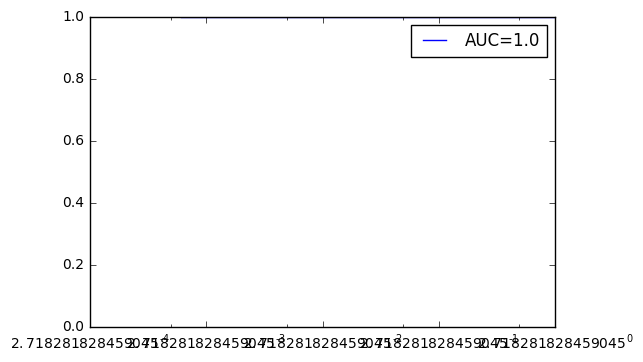

In [105]:
# Code from
# http://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python

from sklearn import metrics
import matplotlib.pyplot as plt
import math

plt.figure(0).clf()

auc = metrics.roc_auc_score(test_labels_200, test_y_hat_200)
fpr, tpr, thresholds = metrics.roc_curve(test_labels_200, test_y_hat_200)
plt.semilogx(basex = math.e)
plt.plot(fpr, tpr, label="AUC="+str(auc))
#plt.plot([0, 1], [0, 1], color='gray')

plt.legend(loc=0)
plt.show()

We note here the perfect accuracy of the lanugage predictions and the AUC of 1.  We believe, as stated, that this is due to the distinctness of written English and Russian.

# Extra Credit - Bidirectional LSTM

We also considered the use of a bidirectional LSTM.  This would not just look at subsequent letters given past letters, but also previous letters given later ones.  We suspected that this would lead to greater accuracy.

In [157]:
path_eng = get_file('eng.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/eng.txt')
text_eng = open(path_eng).read().lower()
print('English Corpus Length:\t', len(text_eng))

path_frn = get_file('frn.txt', origin='https://raw.githubusercontent.com/GT-CSE6240/proj2/master/data/frn.txt')
text_frn = open(path_frn).read().lower()
print('French Corpus Length:\t', len(text_frn))

# Get chars from two texts
chars_from_eng = sorted(list(set(text_eng)))
chars_from_frn = sorted(list(set(text_frn)))

# Combine chars from two languages into one chars list
#######################
# Code between hash lines taken from 
# http://stackoverflow.com/questions/2151517/pythonic-way-to-create-union-of-all-values-contained-in-multiple-lists
results_list = [chars_from_eng, chars_from_frn]
chars = list(set().union(*results_list))
#######################

# Get dictionaries of chars and their index in the chars list
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('Total Chars:\t', len(chars))

# Break up English text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_eng = []
next_chars_eng = []
for i in range(0, len(text_eng) - maxlen, step):
    char5_strings_eng.append(text_eng[i: i + maxlen])
    next_chars_eng.append(text_eng[i + maxlen])
print('English nb sequences:\t', len(char5_strings_eng))

# Break up French text into 5 char segments, shifting one char at a
# time when making new segments
maxlen = 5
step = 1
char5_strings_frn = []
next_chars_frn = []
for i in range(0, len(text_frn) - maxlen, step):
    char5_strings_frn.append(text_frn[i: i + maxlen])
    next_chars_frn.append(text_frn[i + maxlen])
print('French nb sequences:\t', len(char5_strings_frn))

# Get the labels for the datasets
# 1=English, 0=French
labels_eng = np.array([1]*len(char5_strings_eng))
labels_frn = np.array([0]*len(char5_strings_frn))

# Do an 80/20 split to get training and test data for both English and French
training_data_eng, testing_data_eng, training_labels_eng, testing_labels_eng = train_test_split(
        char5_strings_eng, labels_eng, test_size=0.2, random_state=0)

training_data_frn, testing_data_frn, training_labels_frn, testing_labels_frn = train_test_split(
        char5_strings_frn, labels_frn, test_size=0.2, random_state=0)

English Corpus Length:	 10746
French Corpus Length:	 12009
Total Chars:	 44
English nb sequences:	 10741
French nb sequences:	 12004


In [158]:
# Method to vectorize a dataset
def vectorization(char5_strings, maxlen, chars, char_indices, next_chars):
    X = np.zeros((len(char5_strings), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(char5_strings), len(chars)), dtype=np.bool)
    for i, char5_string in enumerate(char5_strings):
        for t, char in enumerate(char5_string):
            X[i, t, char_indices[char]] = 1
        r = next_chars[i]
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

In [159]:
X_train_eng, X_train_labels_eng = vectorization(training_data_eng, maxlen, chars, char_indices, next_chars_eng)
X_test_eng, X_test_labels_eng = vectorization(testing_data_eng, maxlen, chars, char_indices, next_chars_eng)

X_train_frn, X_train_labels_frn = vectorization(training_data_frn, maxlen, chars, char_indices, next_chars_frn)
X_test_frn, X_test_labels_frn = vectorization(testing_data_frn, maxlen, chars, char_indices, next_chars_frn)

The following 3 cells are taken from the following source (and the 2 cells after that take some parts from it) and modified as necessary: https://github.com/fchollet/keras/issues/1629

In [160]:
def fork (model, n=2):
    forks = []
    for i in range(n):
        f = Sequential()
        f.add (model)
        forks.append(f)
    return forks

In [161]:
# ENGLISH MODEL

from keras.layers import Merge
from keras.optimizers import SGD

left = Sequential()
left.add(LSTM(128, input_shape=(maxlen, len(chars))))
print(left.input_shape)
print(left.output_shape)
right = Sequential()
right.add(LSTM(128, input_shape=(maxlen, len(chars)), go_backwards=True))

model = Sequential()
model.add(Merge([left, right], mode='sum'))

#Add second Bidirectional LSTM layer
left, right = fork(model)
model_eng = Sequential()
model_eng.add(Merge([left, right], mode='sum'))


model_eng.add(Dense(len(chars)))
model_eng.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
model_eng.compile(loss='categorical_crossentropy', optimizer=sgd)

(None, 5, 44)
(None, 128)


/Users/sam/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/sam/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [162]:
# FRENCH MODEL

left = Sequential()
left.add(LSTM(128, input_shape=(maxlen, len(chars))))
print(left.input_shape)
print(left.output_shape)
right = Sequential()
right.add(LSTM(128, input_shape=(maxlen, len(chars)), go_backwards=True))

model = Sequential()
model.add(Merge([left, right], mode='sum'))

#Add second Bidirectional LSTM layer
left, right = fork(model)
model_frn = Sequential()
model_frn.add(Merge([left, right], mode='sum'))


model_frn.add(Dense(len(chars)))
model_frn.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
model_frn.compile(loss='categorical_crossentropy', optimizer=sgd)

(None, 5, 44)
(None, 128)


/Users/sam/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/sam/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [163]:
# train the English model
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_eng.fit([X_train_eng, X_train_eng], X_train_labels_eng,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
8592/8592 [==============================] - 7s - loss: 3.0359     
Epoch 2/5
8592/8592 [==============================] - 3s - loss: 2.9524     
Epoch 3/5
8592/8592 [==============================] - 2s - loss: 2.9423     
Epoch 4/5
8592/8592 [==============================] - 2s - loss: 2.9351     
Epoch 5/5
8592/8592 [==============================] - 2s - loss: 2.9286     

--------------------------------------------------
Iteration 2
Epoch 1/5
8592/8592 [==============================] - 3s - loss: 2.9283     
Epoch 2/5
8592/8592 [==============================] - 2s - loss: 2.9215     
Epoch 3/5
8592/8592 [==============================] - 3s - loss: 2.9190     
Epoch 4/5
8592/8592 [==============================] - 2s - loss: 2.9146     
Epoch 5/5
8592/8592 [==============================] - 2s - loss: 2.9139     

--------------------------------------------------
Iteration 3
Epoch 1/5
8592/8592 [=======

In [164]:
# train the French model
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_frn.fit([X_train_frn, X_train_frn], X_train_labels_frn,
              batch_size=128,
              epochs=5)


--------------------------------------------------
Iteration 1
Epoch 1/5
9603/9603 [==============================] - 5s - loss: 2.9363     
Epoch 2/5
9603/9603 [==============================] - 3s - loss: 2.8583     
Epoch 3/5
9603/9603 [==============================] - 3s - loss: 2.8491     
Epoch 4/5
9603/9603 [==============================] - 3s - loss: 2.8370     
Epoch 5/5
9603/9603 [==============================] - 3s - loss: 2.8334     

--------------------------------------------------
Iteration 2
Epoch 1/5
9603/9603 [==============================] - 3s - loss: 2.8328     
Epoch 2/5
9603/9603 [==============================] - 3s - loss: 2.8232     
Epoch 3/5
9603/9603 [==============================] - 3s - loss: 2.8244     
Epoch 4/5
9603/9603 [==============================] - 3s - loss: 2.8228     
Epoch 5/5
9603/9603 [==============================] - 3s - loss: 2.8248     

--------------------------------------------------
Iteration 3
Epoch 1/5
9603/9603 [=======

In [180]:
# Create the 200 test data
test_data_200 = np.zeros((200, maxlen, len(chars)), dtype=np.bool)

# Pick 100 substrings at random from each language
eng_test_indices = np.random.randint(0, X_test_eng.shape[0], size=100)
frn_test_indices = np.random.randint(0, X_test_frn.shape[0], size=100)

# Fill the data
test_data_200[:100] = X_test_eng[eng_test_indices,:,:]
test_data_200[100:] = X_test_frn[frn_test_indices,:,:]

# Create the labels
test_labels_200 = np.concatenate(([1]*100, [0]*100))

In [181]:
# Vectorize test string
def test_vectorization(test_string, maxlen, chars, char_indices):
    test_string_data = []
    # Break up test string
    for ind in range(min(maxlen, len(test_string))):
        test_string_data.append(test_string[:ind])
    # Create X
    X = np.zeros((len(test_string_data), maxlen, len(chars)), dtype=np.bool)
    for i, test_string_entry in enumerate(test_string_data):
        for t, char in enumerate(test_string_entry):
            X[i, t, char_indices[char]] = 1
    return X

In [182]:
test_predict_200 = np.zeros(200)
test_y_hat_200 = np.zeros(200)

for t in range(test_data_200.shape[0]):
    letter_string = ''
    for letter in range(test_data_200[t].shape[0]):
        letter_ind = np.where(test_data_200[t,letter,:]==1)[0][0]
        letter_string += chars[letter_ind]
        if (len(letter_string) >= 5):
            break
    letter_string_vect = test_vectorization(letter_string, maxlen, chars, char_indices)
    
    test_predict_eng = model_eng.predict([letter_string_vect, letter_string_vect], batch_size=1, verbose=1)
    test_predict_frn = model_frn.predict([letter_string_vect, letter_string_vect], batch_size=1, verbose=1)
    total_prob_eng = 1
    total_prob_frn = 1
    for p in range(len(test_predict_eng)):
        if len(np.where(test_data_200[t,p,:]==1)[0]) == 0:
            break
        char_ind = np.where(test_data_200[t,p,:]==1)[0][0]
        # English probability
        char_prob_eng = test_predict_eng[p, char_ind]
        total_prob_eng *= char_prob_eng
        # French probability
        char_prob_frn = test_predict_frn[p, char_ind]
        total_prob_frn *= char_prob_frn
    prediction = 1 if (np.log(total_prob_eng) > np.log(total_prob_frn)) else 0
    test_predict_200[t] = prediction
    test_y_hat_200[t] = np.log(total_prob_eng) - np.log(total_prob_frn)

1/5 [=====>........................] - ETA: 0s

In [183]:
accuracy_vect = np.nonzero(test_labels_200 - test_predict_200)
accuracy = 1 - (len(accuracy_vect[0]) / 200.)
print(accuracy)

0.63


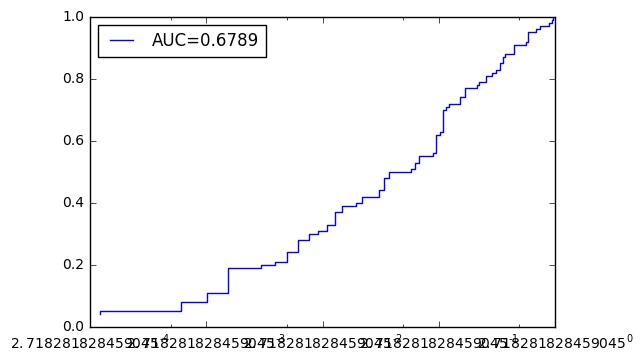

In [184]:
# Code from
# http://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python

from sklearn import metrics
import matplotlib.pyplot as plt
import math

plt.figure(0).clf()

auc = metrics.roc_auc_score(test_labels_200, test_y_hat_200)
fpr, tpr, thresholds = metrics.roc_curve(test_labels_200, test_y_hat_200)
plt.semilogx(basex = math.e)
plt.plot(fpr, tpr, label="AUC="+str(auc))
#plt.plot([0, 1], [0, 1], color='gray')

plt.legend(loc=0)
plt.show()

Surprisingly, the bidirectional LSTM did not clearly outperform the regular LSTM.  While it had a comparable performance, it did not perform as highly as expected.  We saw accuracies ranging from the mid-50% to the 63% shown here.  The AUC is respectable.  Variations in the performance are likely due to randomly sampling 100 strings per language from the test data.

# Extra Credit - Larger Dataset

We were curious as to whether or not a larger dataset might result in better predictive outcomes.  In order to test this, we needed a much longer document for which there were high quality translations into different languages.  We found that the Vatican makes available on its site and in several languages the Compendium to the Catechism of the Catholic Church.  We took a portion of the English and French translations of this document.  We do not profess that our data gathering process or the documents themselves were perfect, primarily with regard to '\n' characters.  Nevertheless, it should be of sufficient quality to test the question at hand.  The English and French Compendium documents were 260 KB and 275KB, respectively, as opposed to the 11 KB and 12 KB human rights documents.  The model performed quite well, achieving accuracies in the mid- to high-60% and a nice AUC value.  The performance was not vastly superior to that of LSTMs with smaller datasets, but it did seem to be among the best performing models we had.

Due to the size of the documents, training the models on them took much longer.  We did this in a separate notebook so we could work on several parts of the project concurrently.  Due to the time required to run it again were we to put it here, we decided to turn it in as a separate notebook.  Please see that notebook for the code and results.